TODO: cover page - to be implemented in latex

# Introduction
## Company description
Mushrooms4all is an organization that aims to promote the collection and use of mushrooms for feeding purposes. However, this organization is aware that there are many mushrooms that are not suitable for human consumption, being dangerous to eat them since they can cause poisoning. Although they have a quite complete database of dangerous/non-dangerous mushrooms, they aim to create a machine learning model that, based on the mushroom characteristics, allows to classify a not known mushroom species as safe or not for human consumption.
## Project goals
Mushrooms4all provides their current dataset of mushrooms that are dangerous and non-dangerous and asked you to create a model that allows to classify a new mushroom as that can cause poisoning or not. They also require having an “application”, or at least, an endpoint/API to query the model. Hence, the deployment of the model is required.

# Project implementation
The project was developed using Python programming language and the results of exploration are delivered in form of this report, together with Jupyter Notebook file. The model will be deployed using Flask and available as REST API.

The following libraries were used during development of the project.

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from lib.functions import plot_confusion_matrix
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy.stats import chi2_contingency

# Data exploration
## Data description
The data was provided in a form of a flat file of the following structure. All variables are categorical string variables. There are no missing values in the dataset.

In [2]:
df = pd.read_csv('../data/mushrooms_v2.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

In [3]:
# independent variable
print(df.filter(regex='^class', axis=1).head())
print(df.filter(regex='^class', axis=1).describe())

  class
0     p
1     e
2     e
3     p
4     e
       class
count   8124
unique     2
top        e
freq    4208


In [4]:
# cap
print(df.filter(regex='^cap-', axis=1).head())
print(df.filter(regex='^cap-', axis=1).describe())

  cap-shape cap-surface cap-color
0         s           f         g
1         x           g         y
2         k           s         n
3         b           y         w
4         b           s         g
       cap-shape cap-surface cap-color
count       8124        8124      8124
unique         6           4        10
top            x           y         n
freq        2429        2574      1488


In [5]:
# gill
print(df.filter(regex='^gill-', axis=1).head())
print(df.filter(regex='^gill-', axis=1).describe())

  gill-attachment gill-spacing gill-size gill-color
0               f            d         n          k
1               d            c         b          k
2               f            w         b          n
3               f            c         n          e
4               n            c         b          o
       gill-attachment gill-spacing gill-size gill-color
count             8124         8124      8124       8124
unique               4            3         2         12
top                  f            c         b          b
freq              4644         4626      4843       1161


In [6]:
# stalk
print(df.filter(regex='^stalk-', axis=1).head())
print(df.filter(regex='^stalk-', axis=1).describe())

  stalk-shape stalk-root stalk-surface-above-ring stalk-surface-below-ring  \
0           e          e                        s                        s   
1           e          c                        y                        y   
2           t          c                        s                        k   
3           t          e                        s                        k   
4           t          b                        s                        s   

  stalk-color-above-ring stalk-color-below-ring  
0                      c                      c  
1                      e                      e  
2                      b                      b  
3                      w                      g  
4                      w                      e  
       stalk-shape stalk-root stalk-surface-above-ring  \
count         8124       8124                     8124   
unique           2          7                        4   
top              t          b                        s   

In [7]:
# veil
print(df.filter(regex='^veil-', axis=1).head())
print(df.filter(regex='^veil-', axis=1).describe())

  veil-type veil-color
0         p          w
1         p          w
2         p          w
3         p          w
4         p          w
       veil-type veil-color
count       8124       8124
unique         2          4
top            p          w
freq        5968       4703


In [8]:
# ring
print(df.filter(regex='^ring-', axis=1).head())
print(df.filter(regex='^ring-', axis=1).describe())

  ring-number ring-type
0           t         p
1           o         p
2           o         p
3           b         n
4           b         z
       ring-number ring-type
count         8124      8124
unique           4         8
top              o         p
freq          4835      2358


In [9]:
# other
print(df.filter(['spore-print-color','population','habitat','bruises','odor'], axis=1).head())
print(df.filter(['spore-print-color','population','habitat','bruises','odor'], axis=1).describe())

  spore-print-color population habitat bruises odor
0                 k          n       u       t    p
1                 u          a       p       t    a
2                 n          v       g       t    l
3                 k          s       u       t    y
4                 w          a       g       f    n
       spore-print-color population habitat bruises  odor
count               8124       8124    8124    8124  8124
unique                 9          6       7       2     9
top                    w          v       d       f     n
freq                1538       2591    2072    4329  2098


## Data analysis
In the following section we analyze frequencies of the variables with respect to the class variable (independent variable).

Observations are very well distributed between dependent and independent variables promising meaningful predictions. Only variables gill-attachment, veil-type and veil-color have high p-value for chi-square test of independence and we may consider removing them from the model in the next section.

Frequency of variable class


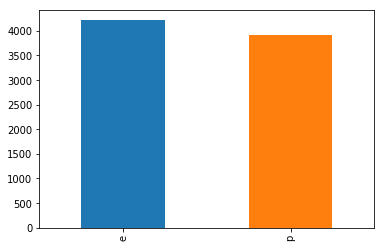

Contingency table for variable class and class
class     e     p   All
class                  
e      4208     0  4208
p         0  3916  3916
All    4208  3916  8124
P-value: 0.0
----------
Frequency of variable cap-shape


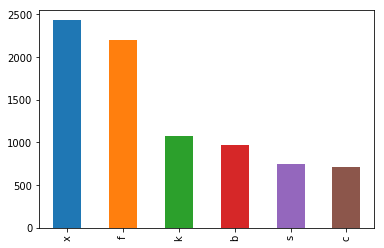

Contingency table for variable class and cap-shape
cap-shape    b    c     f     k    s     x   All
class                                           
e          590  379  1152   450  376  1261  4208
p          378  336  1043   625  366  1168  3916
All        968  715  2195  1075  742  2429  8124
P-value: 5.18647080659e-15
----------
Frequency of variable cap-surface


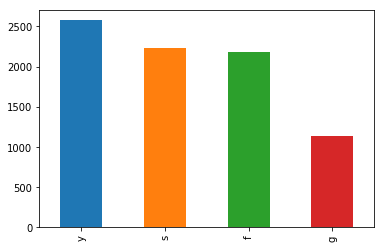

Contingency table for variable class and cap-surface
cap-surface     f     g     s     y   All
class                                    
e            1253   602  1102  1251  4208
p             929   539  1125  1323  3916
All          2182  1141  2227  2574  8124
P-value: 2.02305956576e-09
----------
Frequency of variable cap-color


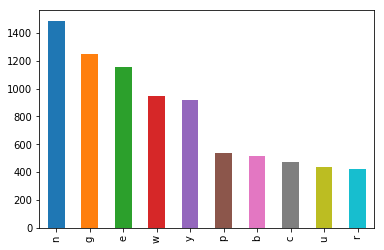

Contingency table for variable class and cap-color
cap-color    b    c     e     g     n    p    r    u    w    y   All
class                                                               
e          259  235   508   679   823  260  236  227  569  412  4208
p          255  234   646   566   665  276  186  212  374  502  3916
All        514  469  1154  1245  1488  536  422  439  943  914  8124
P-value: 2.26104479889e-15
----------
Frequency of variable bruises


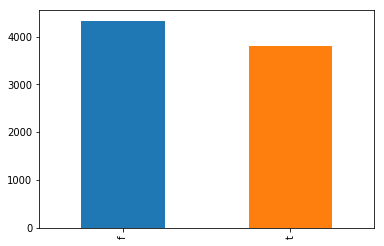

Contingency table for variable class and bruises
bruises     f     t   All
class                    
e        1792  2416  4208
p        2537  1379  3916
All      4329  3795  8124
P-value: 3.86250853843e-89
----------
Frequency of variable odor


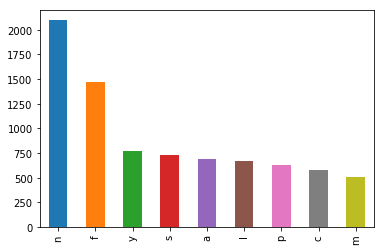

Contingency table for variable class and odor
odor     a    c     f    l    m     n    p    s    y   All
class                                                     
e      448  255   259  438  251  1829  266  223  239  4208
p      241  321  1209  228  253   269  360  506  529  3916
All    689  576  1468  666  504  2098  626  729  768  8124
P-value: 0.0
----------
Frequency of variable gill-attachment


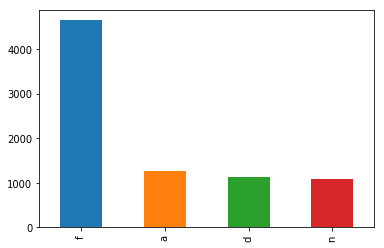

Contingency table for variable class and gill-attachment
gill-attachment     a     d     f     n   All
class                                        
e                 666   592  2385   565  4208
p                 593   534  2259   530  3916
All              1259  1126  4644  1095  8124
P-value: 0.73771615108
----------
Frequency of variable gill-spacing


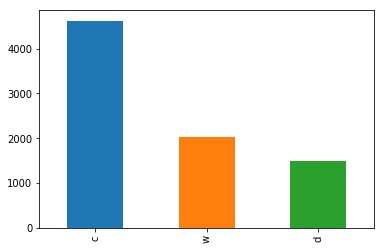

Contingency table for variable class and gill-spacing
gill-spacing     c     d     w   All
class                               
e             2188   732  1288  4208
p             2438   749   729  3916
All           4626  1481  2017  8124
P-value: 4.14197006771e-35
----------
Frequency of variable gill-size


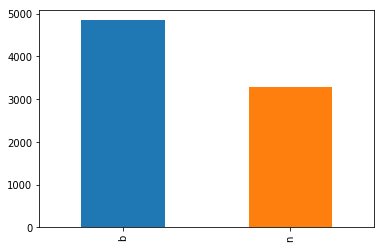

Contingency table for variable class and gill-size
gill-size     b     n   All
class                      
e          2976  1232  4208
p          1867  2049  3916
All        4843  3281  8124
P-value: 4.13161472888e-99
----------
Frequency of variable gill-color


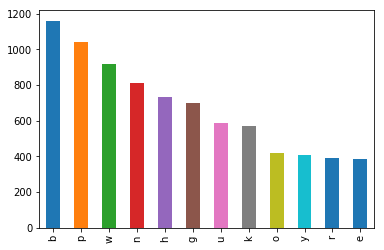

Contingency table for variable class and gill-color
gill-color     b    e    g    h    k    n    o     p    r    u    w    y   All
class                                                                         
e            196  213  313  313  330  610  241   594  184  390  618  206  4208
p            965  171  384  422  240  203  180   448  207  195  297  204  3916
All         1161  384  697  735  570  813  421  1042  391  585  915  410  8124
P-value: 1.29516468724e-197
----------
Frequency of variable stalk-shape


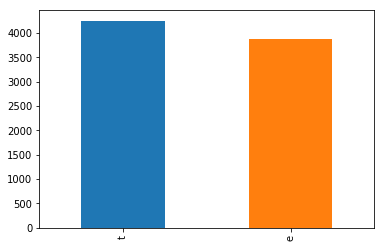

Contingency table for variable class and stalk-shape
stalk-shape     e     t   All
class                        
e            1919  2289  4208
p            1954  1962  3916
All          3873  4251  8124
P-value: 0.00011811541518
----------
Frequency of variable stalk-root


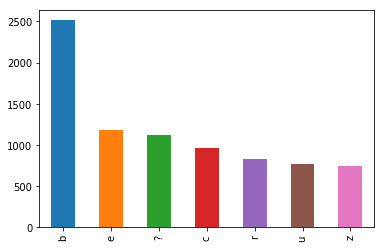

Contingency table for variable class and stalk-root
stalk-root     ?     b    c     e    r    u    z   All
class                                                 
e            320  1302  602   750  458  397  379  4208
p            801  1211  361   427  370  375  371  3916
All         1121  2513  963  1177  828  772  750  8124
P-value: 2.12442334682e-74
----------
Frequency of variable stalk-surface-above-ring


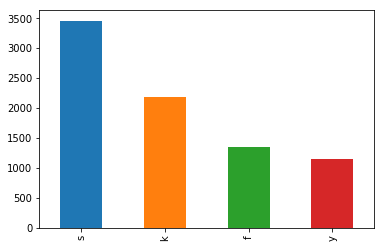

Contingency table for variable class and stalk-surface-above-ring
stalk-surface-above-ring     f     k     s     y   All
class                                                 
e                          741   627  2236   604  4208
p                          602  1551  1222   541  3916
All                       1343  2178  3458  1145  8124
P-value: 6.96763377044e-151
----------
Frequency of variable stalk-surface-below-ring


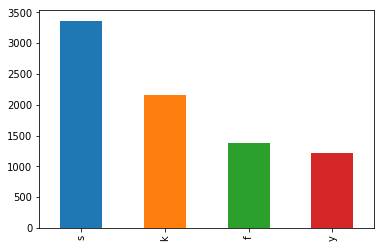

Contingency table for variable class and stalk-surface-below-ring
stalk-surface-below-ring     f     k     s     y   All
class                                                 
e                          788   634  2122   664  4208
p                          599  1526  1241   550  3916
All                       1387  2160  3363  1214  8124
P-value: 2.4097676179e-135
----------
Frequency of variable stalk-color-above-ring


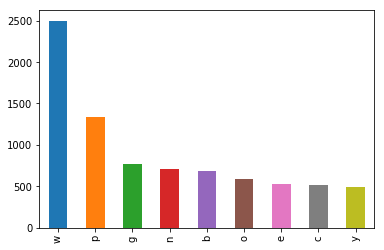

Contingency table for variable class and stalk-color-above-ring
stalk-color-above-ring    b    c    e    g    n    o     p     w    y   All
class                                                                      
e                       236  268  313  502  265  351   523  1514  236  4208
p                       447  250  212  267  444  241   818   987  250  3916
All                     683  518  525  769  709  592  1341  2501  486  8124
P-value: 4.1375397137e-79
----------
Frequency of variable stalk-color-below-ring


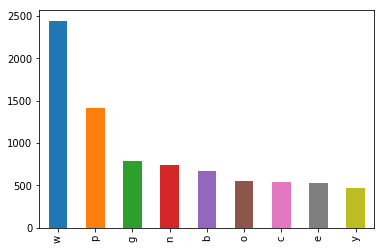

Contingency table for variable class and stalk-color-below-ring
stalk-color-below-ring    b    c    e    g    n    o     p     w    y   All
class                                                                      
e                       247  263  326  542  285  314   539  1477  215  4208
p                       418  271  207  244  452  235   872   969  248  3916
All                     665  534  533  786  737  549  1411  2446  463  8124
P-value: 1.88997250217e-83
----------
Frequency of variable veil-type


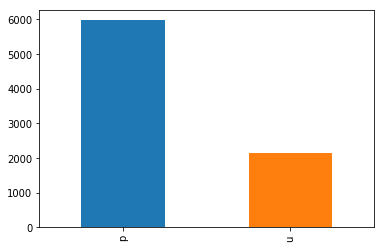

Contingency table for variable class and veil-type
veil-type     p     u   All
class                      
e          3064  1144  4208
p          2904  1012  3916
All        5968  2156  8124
P-value: 0.178508900599
----------
Frequency of variable veil-color


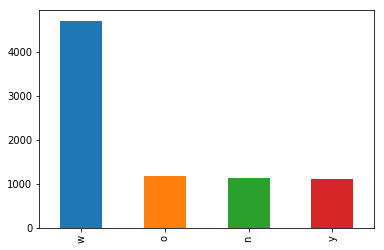

Contingency table for variable class and veil-color
veil-color     n     o     w     y   All
class                                   
e            600   644  2402   562  4208
p            535   538  2301   542  3916
All         1135  1182  4703  1104  8124
P-value: 0.152979746521
----------
Frequency of variable ring-number


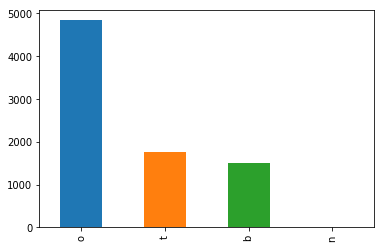

Contingency table for variable class and ring-number
ring-number     b   n     o     t   All
class                                  
e             815   0  2394   999  4208
p             694  11  2441   770  3916
All          1509  11  4835  1769  8124
P-value: 8.93545151572e-09
----------
Frequency of variable ring-type


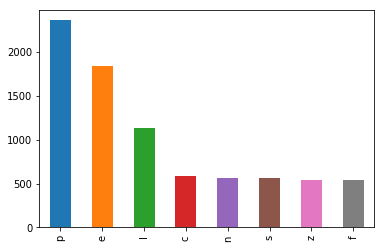

Contingency table for variable class and ring-type
ring-type    c     e    f     l    n     p    s    z   All
class                                                     
e          304   744  295   298  281  1721  291  274  4208
p          284  1098  244   830  286   637  270  267  3916
All        588  1842  539  1128  567  2358  561  541  8124
P-value: 1.55974359525e-171
----------
Frequency of variable spore-print-color


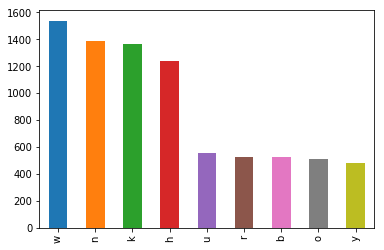

Contingency table for variable class and spore-print-color
spore-print-color    b     h     k     n    o    r    u     w    y   All
class                                                                   
e                  279   269  1026  1053  267  248  322   516  228  4208
p                  245   972   341   335  243  279  229  1022  250  3916
All                524  1241  1367  1388  510  527  551  1538  478  8124
P-value: 1.02360014755e-273
----------
Frequency of variable population


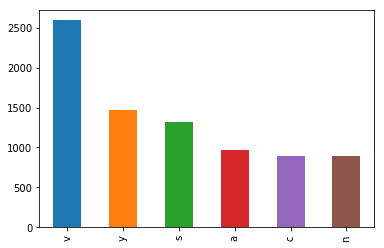

Contingency table for variable class and population
population    a    c    n     s     v     y   All
class                                            
e           590  531  546   793   927   821  4208
p           374  368  347   520  1664   643  3916
All         964  899  893  1313  2591  1464  8124
P-value: 2.47944865698e-84
----------
Frequency of variable habitat


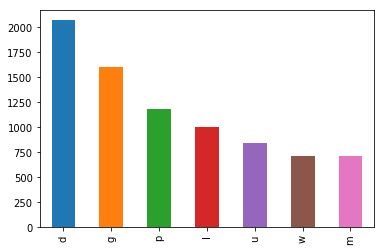

Contingency table for variable class and habitat
habitat     d     g     l    m     p    u    w   All
class                                               
e        1195   963   447  400   408  395  400  4208
p         877   636   558  311   772  450  312  3916
All      2072  1599  1005  711  1180  845  712  8124
P-value: 2.5380342484e-52
----------


In [10]:
for c in df.columns:
    print('Frequency of variable', c)
    df[c].value_counts().plot.bar()
    plt.show()
    class_var = pd.crosstab(index=df["class"], 
                    columns=df[c],
                     margins=True)   # Include row and column totals
    chi2, p, dof, ex = chi2_contingency(class_var.iloc[:-1,:-1])
    print('Contingency table for variable class and', c)
    print(class_var)
    print('P-value:', p)
# contingency for each variable - use if necessary
#     for cc in df.columns:
#         class_var = pd.crosstab(index=df[cc], 
#                         columns=df[c],
#                          margins=True)   # Include row and column totals
#         chi2, p, dof, ex = chi2_contingency(class_var.iloc[:-1,:-1])
#         if p > 0.05:
#             print(p)
#             print('Contingency table for variable', c, 'and', cc)
#             print(class_var)
    print('----------')

# Model training
All models will be trained on 80% of the data and validated on the remaining 20%. The categorical variables are encoded using one-hot encoding.

In [11]:
X=df.drop(labels=['class'], axis=1)
X=pd.get_dummies(X)
features=list(X.columns)
pickle.dump(features, open('../models/features.pickle', 'wb'))

y=pd.get_dummies(df['class'], drop_first=True) # Poisonous=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print(X_train.shape)
print(X_test.shape)

(6499, 127)
(1625, 127)


The following models are trained and tested:

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

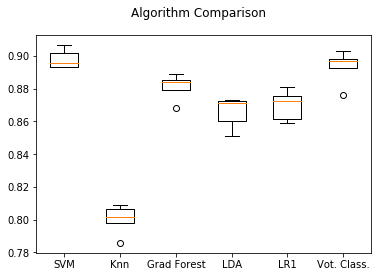

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.965768472159


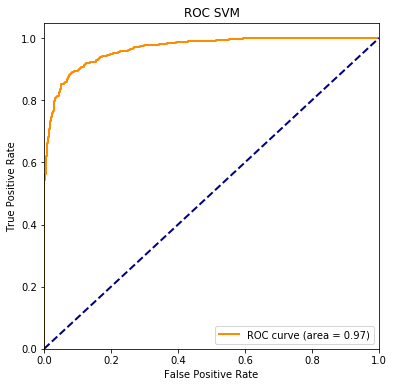

Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.11  0.89]]


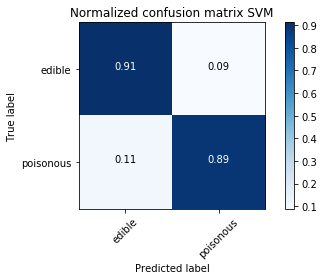

Recall: 0.891025641026
----------


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:57: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AUC: 0.86969883174


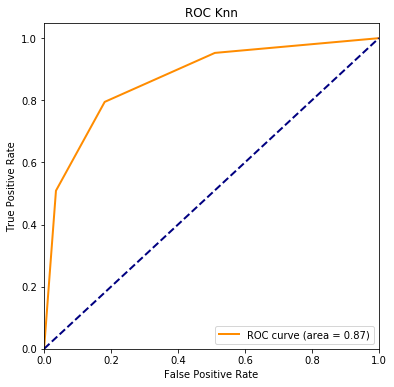

Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.21  0.79]]


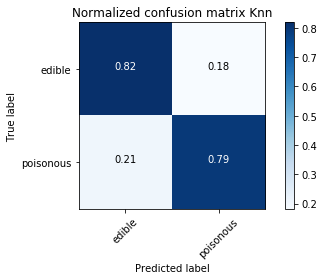

Recall: 0.794871794872
----------
AUC: 0.958922773479


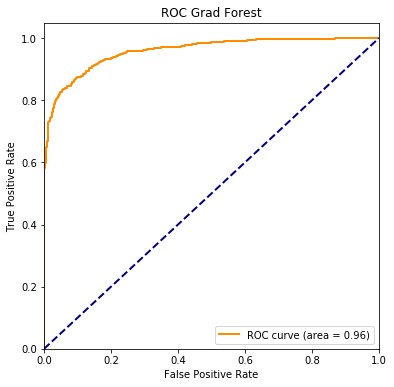

Normalized confusion matrix
[[ 0.92  0.08]
 [ 0.14  0.86]]


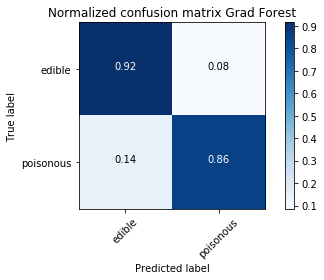

Recall: 0.857692307692
----------
AUC: 0.944207252314


/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


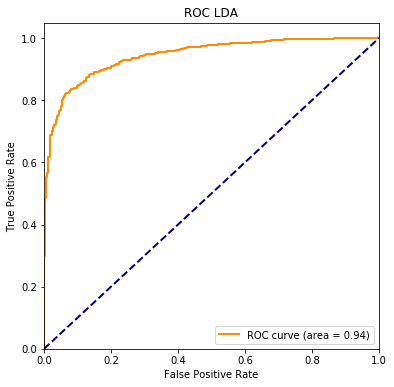

Normalized confusion matrix
[[ 0.9   0.1 ]
 [ 0.15  0.85]]


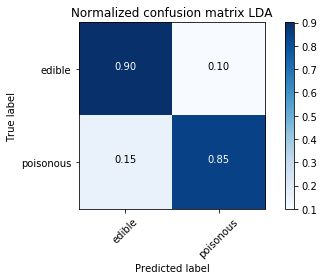

Recall: 0.846153846154
----------
AUC: 0.944175390684


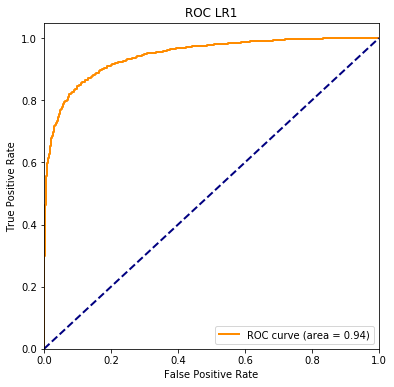

Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.14  0.86]]


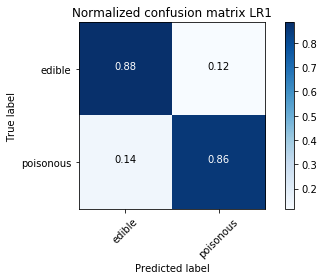

Recall: 0.857692307692
----------


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


AUC: 0.968191473221


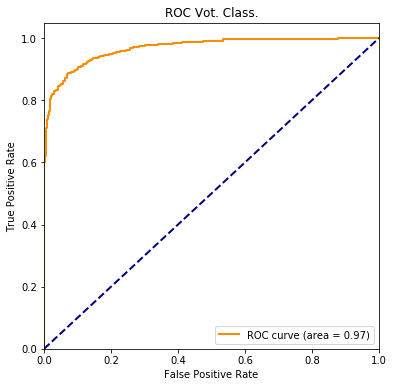

Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.12  0.88]]


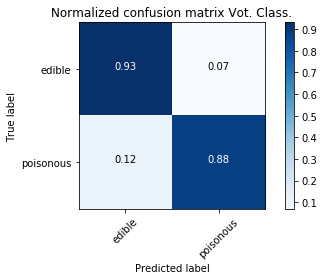

Recall: 0.880769230769
----------


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=241, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
# Create models list that will store the different machine learning models
models = []
svc = SVC(C=241, probability=True)
knn = KNeighborsClassifier(n_neighbors=3)
gforest = GradientBoostingClassifier(n_estimators = 100)
lda = LDA()
lr = LogisticRegression(penalty = "l2", C = 1)

# Appending machine Learning models to be used
models.append(('SVM', svc))
models.append(('Knn', knn))
models.append(("Grad Forest", gforest))
models.append(('LDA', lda))
models.append(('LR1', lr))
models.append(("Vot. Class.", 
               VotingClassifier(estimators=[('svc', svc), ('knn', knn), 
                                            ('forest', gforest),('lda', lda),
                                            ('lr', lr)], 
                                            voting = 'hard', 
                                            weights=[2, 0.6, 1.4, 1, 1])))

# Computes each algorithm stored in models[]usingy k-fold cross validation
# k-fold cross validation train the model k times and tests every time with a different fold
# the mean and the deviation of the accuracies obtained with each iteration is computed
results = []
names = []
mean_var_results = []

scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, shuffle = True)
    cv_results = cross_val_score(model, X, y, cv = kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    mean_var_results.append([cv_results.mean(), cv_results.std()])
     
# Plot boxplot graphic to analyze performance of the algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show() 

# Evaluate the models with mean, accuracy, recall, ROC, and variance for a splitting of 80% for the training set and 20 % for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

models = models[:-1]
models.append(("Vot. Class.", 
               VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('forest', gforest),('lda', lda),('lr', lr)], 
                                            voting = 'soft', 
                                            weights=[2, 0.6, 1.4, 1, 1])))


for name, model in models:
    # display ROC Curve
    model.fit(X_train,y_train)
    y_true = y_test
    y_score = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    roc_auc = auc(fpr,tpr)
    print('AUC: '+str(roc_auc))

    plt.figure(figsize=(6,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC '+ name)
    plt.legend(loc="lower right")
    #     plt.savefig('plots/roc/'+str(i)+'.png', bbox_inches='tight')
    plt.show()
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

#    # Plot non-normalized confusion matrix
#    plt.figure()
#    plot_confusion_matrix(cnf_matrix, classes=['edible', 'poisonous'],
#                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['edible', 'poisonous'], normalize=True,
                          title='Normalized confusion matrix ' + name)

    plt.show()
    
    tn, fp, fn, tp = cnf_matrix.ravel()
    print('Recall:', tp/(tp+fn))
    print('----------')
    
# THIS IS THE FINAL MODEL TO BE USED
svc.fit(X, y)


In [16]:
pickle.dump(svc, open('../models/svc.pickle', 'wb'))

# Deployment
The chosen model was saved as pickle and deployed as a REST API endpoint using Flask.